### Import package

In [1]:
import yahoo_fin.stock_info as si
import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import joblib
import os


MODEL_PATH = "models/lstm"

if not os.path.exists("models"):
    os.makedirs("models")

if not os.path.exists("models/lstm"):
    os.makedirs("models/lstm")
    
do_plot = True
use_gpu = torch.cuda.is_available()

In [28]:
# Data
train_start_date = "01/01/2001"
train_end_date = "06/30/2023"
lookback = 20
window = 5
batch_size = 32

val_start_date = "07/01/2023"
val_end_date = "09/30/2023"

test_start_date = "09/30/2023"
test_end_date = "01/11/2024"

# Training
hidden_dim = 64
output_dim = 1
num_layers = 3

lr = 1e-4
num_epochs = 100
early_stopping_patience = 20

### Load data

In [3]:
train = si.get_data("aapl", start_date=train_start_date, end_date=train_end_date)[["close"]]
len(train)

5658

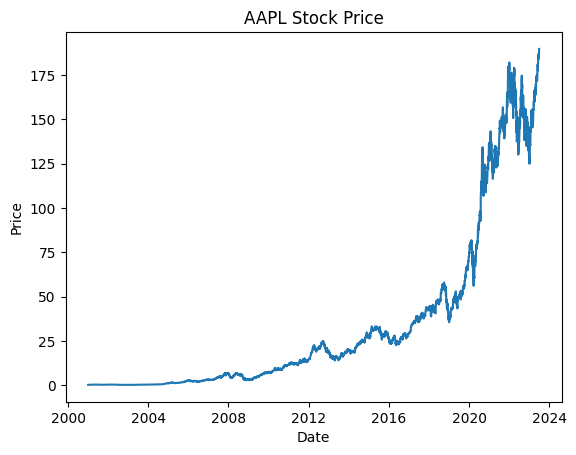

In [4]:
if do_plot:
    plt.plot(train)
    plt.title("AAPL Stock Price")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

/var/folders/9k/_vz3shh92wq2gs0dz81qxnjm0000gn/T/ipykernel_90035/1893061032.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_transformed["close"] = train_transformed.close[random_target_index].values


,close
2001-01-02,0.058839
2001-01-03,0.062229
2001-01-04,0.058839
2001-01-05,0.058839
2001-01-08,0.073527
...,...
2023-06-23,0.942963
2023-06-26,0.979799
2023-06-27,0.995511
2023-06-28,1.000000


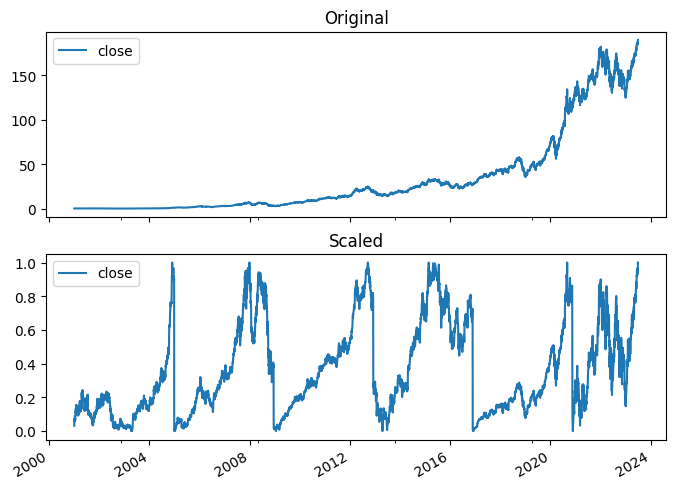

In [5]:
train_transformed = train.copy(deep=True)
scaler = MinMaxScaler()
smoothing_window_size = 1000
s = []
scaler.fit(train)
for di in range(0, len(train),smoothing_window_size):
    scaler.fit(train[di:di+smoothing_window_size])
    s.append(scaler)
    train_transformed[di:di+smoothing_window_size] = scaler.transform(train[di:di+smoothing_window_size])

if do_plot:
    fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    train.plot(ax=ax[0], title="Original")
    train_transformed.plot(ax=ax[1], title="Scaled")

# generate randomly sampled target
offset = np.random.randint(low=0, high=5, size=len(train_transformed))
random_target_index = np.clip(np.arange(len(train_transformed)) + offset, a_min=0, a_max=len(train_transformed)-1)
train_transformed["close"] = train_transformed.close[random_target_index].values
train_transformed

In [6]:
# Data Augmentation
train_transformed = pd.concat([train_transformed]+[train_transformed.shift(i) for i in range(1, lookback)], axis=1)
train_transformed.columns = ["close"] + [f"lag_{i}" for i in range(1, lookback)]
train_transformed = train_transformed.dropna()

In [7]:
# for s in [-1, -2, -3]:
#     train_transformed = pd.concat(
#         [
#             train_transformed, 
#             pd.concat([train_transformed.close.shift(-3), train_transformed.drop("close", axis=1)], axis=1)
#         ]
#     ) 

In [8]:
# train_transformed_aug1 = pd.concat([train_transformed.close.shift(-1)]+[train_transformed.drop("close",axis=1)], axis=1).dropna()  # here close is the target from the next day.
# train_transformed_aug2 = pd.concat([train_transformed.close.shift(-2)]+[train_transformed.drop("close",axis=1)], axis=1).dropna()  # close is target 2 days ahead
# train_transformed_aug3 = pd.concat([train_transformed.close.shift(-3)]+[train_transformed.drop("close",axis=1)], axis=1).dropna()  # close is target 3 days ahead

# train_transformed_aug = pd.concat([train_transformed]+[train_transformed_aug1]+[train_transformed_aug2]+[train_transformed_aug3], axis=0)
# train_transformed_aug

### Validation data

,close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
2023-07-31,1.000000,0.976172,0.875865,0.925058,0.891237,0.857802,0.826672,0.872406,0.948117,0.895465,0.905458,0.778632,0.772867,0.743275,0.678325,0.698694,0.778247,0.821676,0.803229,0.846657
2023-08-01,0.967717,1.000000,0.976172,0.875865,0.925058,0.891237,0.857802,0.826672,0.872406,0.948117,0.895465,0.905458,0.778632,0.772867,0.743275,0.678325,0.698694,0.778247,0.821676,0.803229
2023-08-02,0.851268,0.967717,1.000000,0.976172,0.875865,0.925058,0.891237,0.857802,0.826672,0.872406,0.948117,0.895465,0.905458,0.778632,0.772867,0.743275,0.678325,0.698694,0.778247,0.821676
2023-08-03,0.797079,0.851268,0.967717,1.000000,0.976172,0.875865,0.925058,0.891237,0.857802,0.826672,0.872406,0.948117,0.895465,0.905458,0.778632,0.772867,0.743275,0.678325,0.698694,0.778247
2023-08-04,0.444274,0.797079,0.851268,0.967717,1.000000,0.976172,0.875865,0.925058,0.891237,0.857802,0.826672,0.872406,0.948117,0.895465,0.905458,0.778632,0.772867,0.743275,0.678325,0.698694


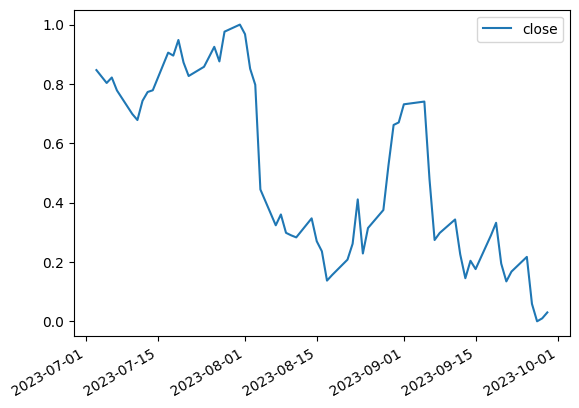

In [9]:
val = si.get_data("aapl", start_date=val_start_date, end_date=val_end_date)[["close"]]
val_transformed = val.copy(deep=True)
val_transformed[:] = s[-1].fit_transform(val) #use last train scaler to scale validation data
val_transformed.plot()
val_transformed = pd.concat([val_transformed]+[val_transformed.shift(i) for i in range(1, lookback)], axis=1)  
val_transformed.columns = ["close"] + [f"lag_{i}" for i in range(1,lookback)]
val_transformed = val_transformed.dropna()
val_transformed.head()

### Data preprosessing

In [10]:
def get_X_y(train):
    y = train["close"]
    X = train.drop(["close"], axis=1)
    return X, y

train_X, train_y = get_X_y(train_transformed)
val_X, val_y = get_X_y(val_transformed)

In [11]:
train_X = torch.tensor(train_X.values, dtype=torch.float32).unsqueeze(2)
X_val = torch.tensor(val_X.values, dtype=torch.float32).unsqueeze(2)

train_dataset = TensorDataset(train_X, torch.tensor(train_y, dtype=torch.float32).flatten())
val_dataset = TensorDataset(X_val, torch.tensor(val_y, dtype=torch.float32).flatten())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)    # why shuffle = True? (to avoid overfitting)
val_loader = DataLoader(val_dataset, batch_size=batch_size*4, shuffle=False)

assert train_dataset.tensors[0].shape[1] == lookback-1 # drop lag 0 

/var/folders/9k/_vz3shh92wq2gs0dz81qxnjm0000gn/T/ipykernel_90035/4025167369.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_dataset = TensorDataset(train_X, torch.tensor(train_y, dtype=torch.float32).flatten())
/var/folders/9k/_vz3shh92wq2gs0dz81qxnjm0000gn/T/ipykernel_90035/4025167369.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_dataset = TensorDataset(X_val, torch.tensor(val_y, dtype=torch.float32).flatten())


### Model

In [12]:
class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, device="cpu"):
        super(StockLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            # nn.Sigmoid()
        )
        
        self.device = device
        
    def forward(self, x):
        if self.device == "cuda":
            x = x.cuda()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=self.device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=self.device).requires_grad_()
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        
        return out
    

def validate(test_loader):
    val_losses = []
    val_accs = []
    model.eval()
    with torch.no_grad():
        for X_batch_t, y_batch_t in test_loader:
            y_val_pred = model(X_batch_t).squeeze()
            y_batch_t = y_batch_t.to(y_val_pred.device)
            val_loss = loss_fn(y_val_pred, y_batch_t)
            val_acc = ((y_val_pred > 0.5) == y_batch_t).sum().item() / len(y_batch_t)
            val_losses.append(val_loss.item())
            val_accs.append(val_acc)
    model.train()
    return np.mean(val_losses), np.mean(val_accs)

### Training

In [13]:
# Define Model
device = "cuda" if use_gpu else "cpu"
model = StockLSTM(input_dim=1, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, device=device)
if use_gpu:
    model.cuda()

loss_fn = nn.MSELoss()
# loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=5, verbose=True, )

history = np.zeros((num_epochs, len(train_loader)))
val_losses = []
min_val_loss = np.inf
min_val_loss_epoch = -1
best_model = None

# seed everything
torch.manual_seed(7)
np.random.seed(7)

for t in range(num_epochs):
    with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (X_batch, y_batch) in pbar:
            y_pred = model(X_batch).squeeze()
            y_batch = y_batch.to(y_pred.device)
            loss = loss_fn(y_pred, y_batch)
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            if i % 10 == 0 and i != 0:
                pbar.set_description(f"Epoch {t}, MSE: {loss.item():.4f}")
            history[t, i] = loss.item()
            
        val_loss_epoch, val_acc_epoch = validate(val_loader)
        pbar.set_postfix(val_loss=val_loss_epoch, val_acc=val_acc_epoch)
        pbar.refresh()
        val_losses.append(val_loss_epoch)
        # lr_scheduler.step(val_loss_epoch)
        
    # Early stopping
    if val_loss_epoch < min_val_loss:
        min_val_loss = val_loss_epoch
        min_val_loss_epoch = t
        best_model = model.state_dict()
    
    elif t - min_val_loss_epoch > early_stopping_patience:
        print(f"Stopping early at epoch {t}")
        break

# Load best model
model.load_state_dict(best_model)

Epoch 99, MSE: 0.0011: 100%|██████████| 177/177 [00:02<00:00, 60.12it/s]


<All keys matched successfully>

In [27]:
# Save best model
torch.save(model.state_dict(), f"{MODEL_PATH}/model.pth") #save state.dict instead of model to solve compability issue on fastAPI
joblib.dump(s[-1], f"{MODEL_PATH}/scaler.pkl") # save last training scaler

['models/lstm/scaler.pkl']

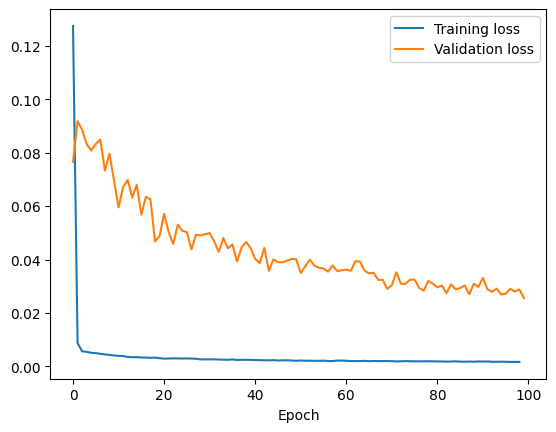

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.mean(axis=1)[:t], label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")

plt.legend()
plt.show()

### Visualise validation data performance

In [16]:
y_pred_list = []
test_losses = []
# test_accs = []

with torch.no_grad():
    for X_batch_t, y_batch_t in val_loader:
        y_test_pred = model(X_batch_t).squeeze()
        y_batch_t = y_batch_t.to(y_test_pred.device)
        y_pred_list.append(y_test_pred)
        test_loss = loss_fn(y_test_pred, y_batch_t)
        
        test_losses.append(test_loss.item())
        
test_loss = np.mean(test_losses)
print(f"Test loss: {test_loss:.4f}")

Test loss: 0.0229


In [17]:
len(val_dataset), len(torch.concat(y_pred_list)), len(val_transformed[["close"]])

(44, 44, 44)

In [18]:
target = val_transformed[["close"]]
rolling_mean_preds = target.ewm(span=5, adjust=False).mean().values

lstm_preds = torch.concat(y_pred_list).cpu().numpy()

true_targets = val_transformed[["close"]].to_numpy().flatten()

print(f"The rolling mean loss is {str(loss_fn(torch.tensor(rolling_mean_preds[3:-1]), torch.tensor(true_targets[4:])).item())}")
print(f"The lstm loss is {str(loss_fn(torch.tensor(lstm_preds[4:]), torch.tensor(true_targets[4:])).item())}")

The rolling mean loss is 0.06644506899863158
The lstm loss is 0.02471067601880425


/Users/chia-hsinlin/opt/anaconda3/envs/api_test/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


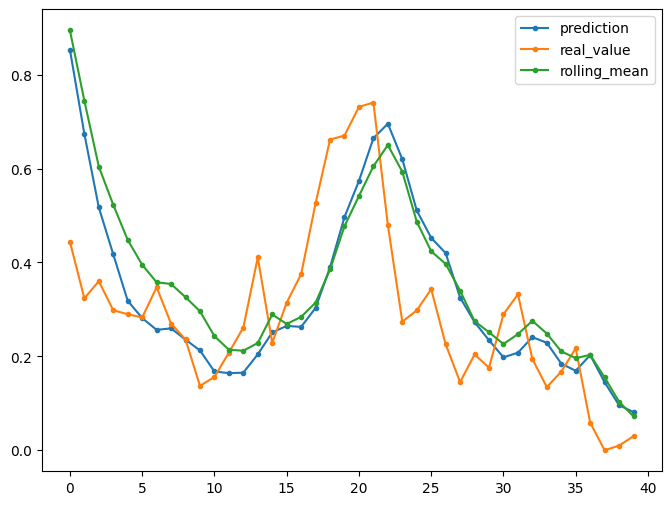

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lstm_preds[4:], label="prediction", marker='.')
ax.plot(val_transformed[["close"]].to_numpy()[4:].flatten().tolist(), label="real_value", marker='.')
ax.plot(rolling_mean_preds[3:-1], label="rolling_mean", marker='.')
plt.legend()

### Test

,close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
2024-01-10,0.605688,0.565335,0.581476,0.413144,0.441199,0.531130,0.584551,0.849347,0.889700,0.873174,0.869332,0.890469,0.931975,0.937740,1.018832,0.978478,1.043044,1.063797,1.058033,0.933129
2024-01-09,0.565335,0.581476,0.413144,0.441199,0.531130,0.584551,0.849347,0.889700,0.873174,0.869332,0.890469,0.931975,0.937740,1.018832,0.978478,1.043044,1.063797,1.058033,0.933129,0.874327
2024-01-08,0.581476,0.413144,0.441199,0.531130,0.584551,0.849347,0.889700,0.873174,0.869332,0.890469,0.931975,0.937740,1.018832,0.978478,1.043044,1.063797,1.058033,0.933129,0.874327,0.971561
2024-01-05,0.413144,0.441199,0.531130,0.584551,0.849347,0.889700,0.873174,0.869332,0.890469,0.931975,0.937740,1.018832,0.978478,1.043044,1.063797,1.058033,0.933129,0.874327,0.971561,0.916219
2024-01-04,0.441199,0.531130,0.584551,0.849347,0.889700,0.873174,0.869332,0.890469,0.931975,0.937740,1.018832,0.978478,1.043044,1.063797,1.058033,0.933129,0.874327,0.971561,0.916219,0.841276


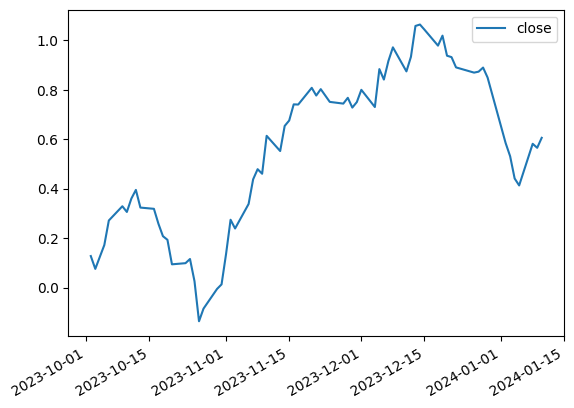

In [31]:
test = si.get_data("aapl", start_date=test_start_date, end_date=test_end_date)[["close"]]
test_transformed = test.copy(deep=True)
test_transformed[:] = s[-1].transform(test)
test_transformed.plot()
test_transformed = pd.concat([test_transformed]+[test_transformed.shift(i) for i in range(1,20)], axis=1)
test_transformed.columns = ["close"] + [f"lag_{i}" for i in range(1,20)]
test_transformed = test_transformed.dropna()
test_transformed.iloc[::-1,:].head()

In [32]:
X_test, y_test = get_X_y(test_transformed)
test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(2), torch.tensor(y_test, dtype=torch.float32).flatten())
test_loader = DataLoader(test_dataset, batch_size=batch_size*4, shuffle=False)

test_losses = []
test_accs = []
y_pred_list = []
with torch.no_grad():
    for X_batch_t, y_batch_t in test_loader:
        y_test_pred = model(X_batch_t).squeeze()
        y_pred_list.append(y_test_pred)
        test_loss = loss_fn(y_test_pred, y_batch_t)
        test_losses.append(test_loss.item())
test_loss = np.mean(test_losses)
print(f"Test loss: {test_loss:.4f}")


Test loss: 0.0121


/var/folders/9k/_vz3shh92wq2gs0dz81qxnjm0000gn/T/ipykernel_90035/93807065.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(2), torch.tensor(y_test, dtype=torch.float32).flatten())


In [33]:
target = test_transformed[["close"]]
rolling_mean_preds = target.ewm(span=5, adjust=False).mean().values
lstm_preds = torch.concat(y_pred_list).cpu().numpy()
true_targets = test_transformed[["close"]].to_numpy().flatten()

print("The rolling mean loss is " +str(loss_fn(torch.tensor(rolling_mean_preds[3:-1]), torch.tensor(true_targets[4:])).item()))
print("The lstm loss is " +str(loss_fn(torch.tensor(lstm_preds[4:]), torch.tensor(true_targets[4:])).item()))

The rolling mean loss is 0.10713203898655572
The lstm loss is 0.012342584465483633


/Users/chia-hsinlin/opt/anaconda3/envs/api_test/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([47])) that is different to the input size (torch.Size([47, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


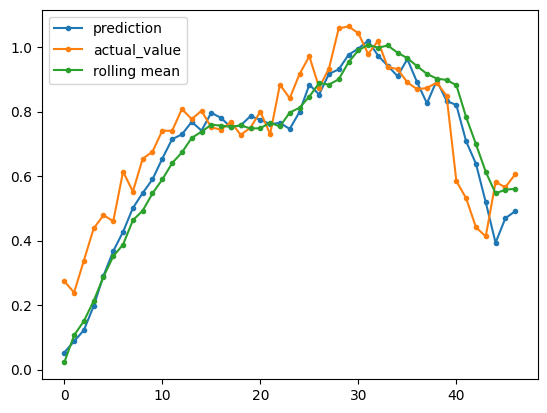

In [39]:
plt.plot(y_pred_list[0][4:].numpy(), label="prediction", marker='.')
plt.plot(test_transformed[["close"]][4:].to_numpy(), label="actual_value",marker='.')
plt.plot(rolling_mean_preds[3:-1], label="rolling mean",marker='.')
plt.legend()

### Plot prediction on original scale

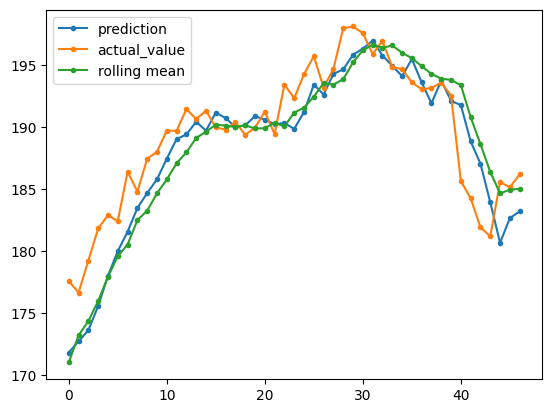

In [49]:
plt.plot(s[-1].inverse_transform(y_pred_list[0][4:].reshape(-1,1)), label="prediction", marker='.')
plt.plot(s[-1].inverse_transform(test_transformed[["close"]][4:].to_numpy()), label="actual_value",marker='.')
plt.plot(s[-1].inverse_transform(rolling_mean_preds[3:-1]), label="rolling mean",marker='.')
plt.xticks = test_transformed.index.strftime("%m/%d/%Y")
plt.legend()

### Multi-step prediction

In [24]:
steps = 30
x_1_test = X_test.iloc[0,:]
x_1_test = x_1_test.values.tolist()

long_term_pred = []
for step in range(0, steps):
    x = torch.tensor(x_1_test, dtype=torch.float32).unsqueeze(1).unsqueeze(0)
    y_test_pred = model(x).squeeze().detach().item()
    long_term_pred.append(y_test_pred)
    x_1_test.append(y_test_pred)
    x_1_test.pop(0)

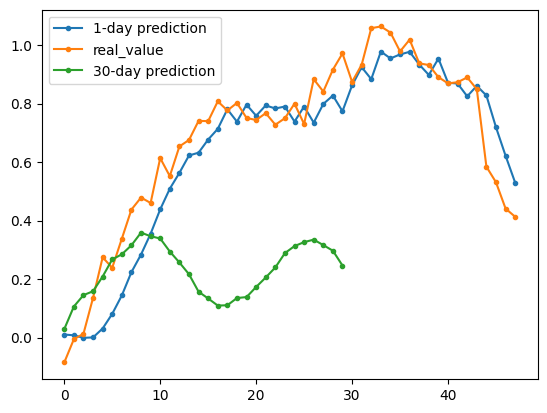

In [25]:
plt.plot(y_pred_list[0].numpy(), label="1-day prediction", marker=".")
plt.plot(test_transformed[["close"]].to_numpy(), label="real_value",marker=".")
plt.plot(long_term_pred, label="30-day prediction",marker=".")
plt.legend()